<a href="https://colab.research.google.com/github/Abinanthan02/amazon_sales_data_analysis/blob/main/amazon_sales_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/drive/MyDrive/Amazon/amazon.csv')

Dataset shape: (1465, 16)

Columns:
 ['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']

Sample rows:
   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   

                                            category discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...             ₹399   
1  Computers&Accessories|Accessories&Peripherals|...             ₹199   

  actual_price discount_percentage rating rating_count  \
0       ₹1,099                 64%    4.2       24,269   
1         ₹349                 43%    4.0       43,994   

                                       about_product  \
0  High Compatibility : Compatible With iPhone 12

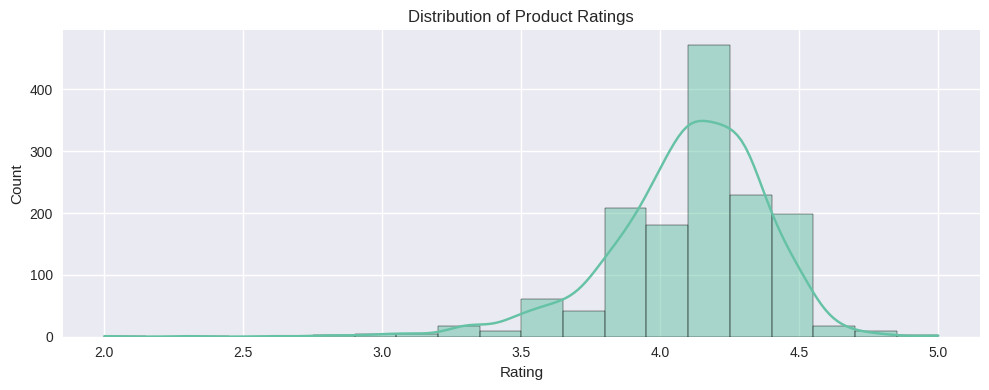

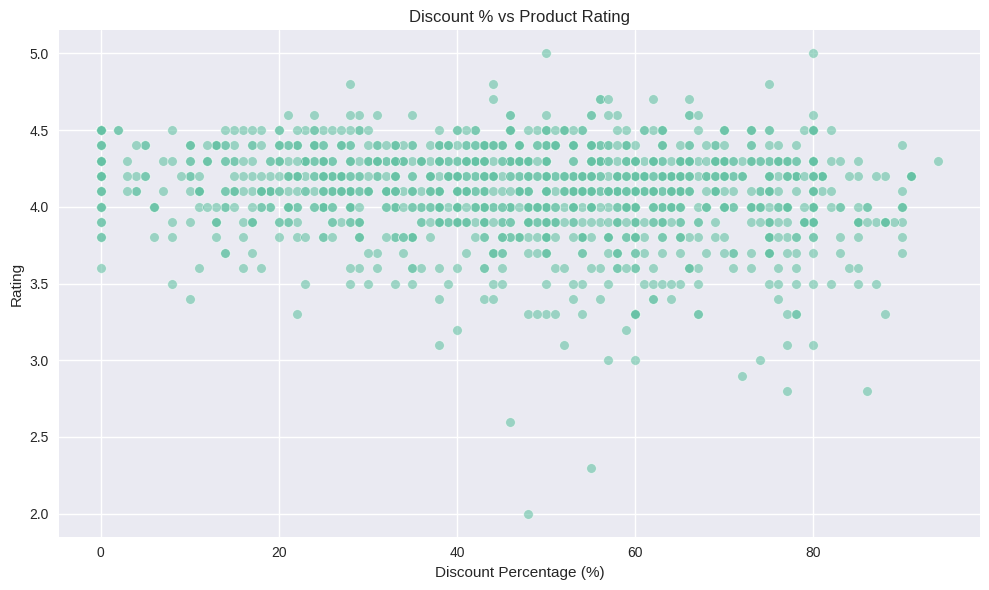


Top 10 Categories by Avg Rating:
                       avg_rating  product_count  avg_discount
main_category                                                 
OfficeProducts           4.309677             31     12.354839
Toys&Games               4.300000              1      0.000000
HomeImprovement          4.250000              2     57.500000
Computers&Accessories    4.155654            451     53.920177
Electronics              4.081749            526     50.828897
Home&Kitchen             4.040716            447     40.174497
Health&PersonalCare      4.000000              1     53.000000
MusicalInstruments       3.900000              2     46.000000
Car&Motorbike            3.800000              1     42.000000


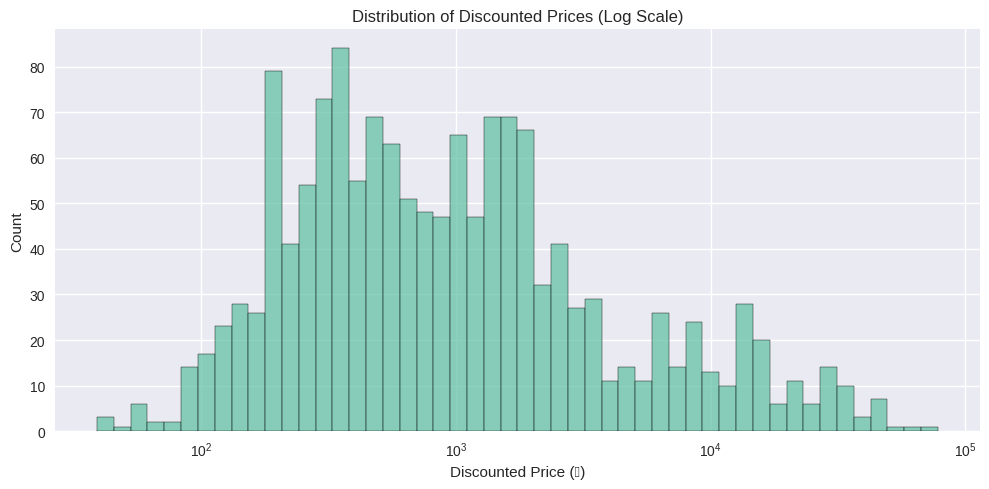


Top 3 Value Products per Category:
            main_category                                       product_name  \
0           Car&Motorbike  Reffair AX30 [MAX] Portable Air Purifier for C...   
1   Computers&Accessories  AmazonBasics USB 2.0 Cable - A-Male to B-Male ...   
2   Computers&Accessories  AmazonBasics USB 2.0 Cable - A-Male to B-Male ...   
3   Computers&Accessories  AmazonBasics USB 2.0 - A-Male to A-Female Exte...   
4             Electronics  Amazon Basics High-Speed HDMI Cable, 6 Feet (2...   
5             Electronics  AmazonBasics Flexible Premium HDMI Cable (Blac...   
6             Electronics  AmazonBasics Flexible Premium HDMI Cable (Blac...   
7     Health&PersonalCare  Dr Trust Electronic Kitchen Digital Scale Weig...   
8            Home&Kitchen  Pigeon Polypropylene Mini Handy and Compact Ch...   
9            Home&Kitchen  Instant Pot Air Fryer, Vortex 2QT, Touch Contr...   
10           Home&Kitchen  Pigeon by Stovekraft Amaze Plus Electric Kettl...   
11  

In [10]:
# amazon_sales_analysis.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

# ----------------------------
# 1. Load and Inspect Data
# ----------------------------
# Use the correct path to the CSV file in Google Drive
df = pd.read_csv('/content/drive/MyDrive/Amazon/amazon.csv')

print("Dataset shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nSample rows:")
print(df.head(2))

# ----------------------------
# 2. Data Cleaning
# ----------------------------

# Clean price columns (remove ₹, commas, convert to float)
def clean_price(price_str):
    if pd.isna(price_str):
        return np.nan
    # Remove '₹' and commas, handle ranges like "₹1,299"
    price_str = str(price_str).replace('₹', '').replace(',', '').strip()
    try:
        return float(price_str)
    except:
        return np.nan

df['discounted_price'] = df['discounted_price'].apply(clean_price)
df['actual_price'] = df['actual_price'].apply(clean_price)

# Clean discount_percentage (remove % and convert to float)
df['discount_percentage'] = df['discount_percentage'].astype(str).str.replace('%', '').astype(float)

# Clean rating_count (e.g., "4,951" → 4951)
df['rating_count'] = df['rating_count'].astype(str).str.replace(',', '').astype(float)

# Convert rating to numeric, coercing errors to NaN
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')


# Extract main category (first part before '|')
df['main_category'] = df['category'].str.split('|').str[0]

# Remove rows with missing critical info
df = df.dropna(subset=['discounted_price', 'rating', 'rating_count', 'main_category'])

print("\nCleaned dataset shape:", df.shape)

# ----------------------------
# 3. Feature Engineering
# ----------------------------

# Create a 'value_score' = rating * log(rating_count) * (1 + discount_percentage/100)
# Higher = better value (quality + popularity + discount)
df['log_rating_count'] = np.log1p(df['rating_count'])
df['value_score'] = df['rating'] * df['log_rating_count'] * (1 + df['discount_percentage'] / 100)

# ----------------------------
# 4. Exploratory Data Analysis
# ----------------------------

# 4.1 Distribution of Ratings
plt.figure(figsize=(10, 4))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('rating_dist.png')
plt.show()

# 4.2 Discount vs Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='discount_percentage', y='rating', alpha=0.6)
plt.title('Discount % vs Product Rating')
plt.xlabel('Discount Percentage (%)')
plt.ylabel('Rating')
plt.tight_layout()
plt.savefig('discount_vs_rating.png')
plt.show()

# 4.3 Top 10 Categories by Average Rating
top_cats = df.groupby('main_category').agg(
    avg_rating=('rating', 'mean'),
    product_count=('rating', 'size'),
    avg_discount=('discount_percentage', 'mean')
).sort_values('avg_rating', ascending=False).head(10)

print("\nTop 10 Categories by Avg Rating:")
print(top_cats)

# 4.4 Price Distribution (discounted)
plt.figure(figsize=(10, 5))
sns.histplot(df['discounted_price'], bins=50, log_scale=True)
plt.title('Distribution of Discounted Prices (Log Scale)')
plt.xlabel('Discounted Price (₹)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('price_dist.png')
plt.show()

# ----------------------------
# 5. Best Value Products by Category
# ----------------------------

def get_top_value_products(df, top_n=5):
    top_products = df.groupby('main_category').apply(
        lambda x: x.nlargest(top_n, 'value_score')
    ).reset_index(drop=True)
    return top_products[['main_category', 'product_name', 'brand', 'rating', 'rating_count',
                         'discounted_price', 'actual_price', 'discount_percentage', 'value_score']]

# Try to extract brand from product_name (simple heuristic)
def extract_brand(name):
    name = str(name)
    common_brands = ['boAt', 'Ambrane', 'Portronics', 'Samsung', 'Redmi', 'OnePlus', 'TP-Link',
                     'Amazon Basics', 'Classmate', 'Faber-Castell', 'Parker', 'Logitech', 'Fire-Boltt']
    for brand in common_brands:
        if brand.lower() in name.lower():
            return brand
    return 'Other'

df['brand'] = df['product_name'].apply(extract_brand)

# Get top value products
top_value = get_top_value_products(df, top_n=3)
print("\nTop 3 Value Products per Category:")
print(top_value.head(15))

# Save to CSV
top_value.to_csv('top_value_products.csv', index=False)

# ----------------------------
# 6. Category-wise Summary Dashboard
# ----------------------------

summary = df.groupby('main_category').agg(
    avg_rating=('rating', 'mean'),
    total_products=('product_name', 'count'),
    avg_discount=('discount_percentage', 'mean'),
    median_price=('discounted_price', 'median'),
    top_brand=('brand', lambda x: x.mode()[0] if not x.mode().empty else 'N/A')
).round(2).sort_values('avg_rating', ascending=False)

print("\nCategory Summary:")
print(summary)

summary.to_csv('category_summary.csv')

# ----------------------------
# 7. Bonus: Most Discounted High-Rated Products
# ----------------------------

high_value_deals = df[
    (df['rating'] >= 4.0) &
    (df['rating_count'] >= 1000) &
    (df['discount_percentage'] >= 50)
].sort_values('discount_percentage', ascending=False).head(10)

print("\nTop 10 High-Rated, Highly Discounted Products:")
print(high_value_deals[['product_name', 'brand', 'rating', 'rating_count', 'discount_percentage', 'discounted_price']])

high_value_deals.to_csv('high_value_deals.csv', index=False)

print("\n✅ Analysis complete! Files saved:")
print("- top_value_products.csv")
print("- category_summary.csv")
print("- high_value_deals.csv")
print("- rating_dist.png")
print("- discount_vs_rating.png")
print("- price_dist.png")